In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import datetime
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords
import prepare
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from keras import layers

import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval


from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## Initial Planning Analysis

In [1]:
# # read in primary utterances csv for dataframe
# df = pd.read_csv('./utterances.csv')
# df.head()

In [ ]:
# # find utterance count per episode
# df.episode.value_counts()

In [ ]:
# # find utterance count per episode
# test = df.episode.value_counts() < 2
# test.sum()

In [ ]:
# # pull in episodes df
# ep_df = pd.read_csv('./episodes.csv')
# ep_df.head()

In [ ]:
# # check episode content to see if it matches episode id
# df[df.episode == 92554].utterance.to_list()

In [ ]:
# # check ep_df.id = df.episode
# ep_df[ep_df.id == 92554].title.to_list()

### Initial takeaways
There are episodes with one utterance, showing less interview setting and more reporting.

ep_df.id == df.episode

### Acquire


In [ ]:
# df = pd.read_csv('./utterances.csv')
# ep_df = pd.read_csv('./episodes.csv')


In [ ]:
# df['speaker'] = df.speaker.str.lower()
# df['program'] = df.program.str.lower()
# df['title'] = df.title.str.lower()

In [ ]:
# # joining utterances df ('df') and episodes on 'id'
# joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
# joined_df.drop(columns = ['id'], inplace=True)
# joined_df.rename(columns={'episode':'episode_id'}, inplace = True)

In [ ]:
# joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')

In [ ]:
# df = acquire.get_df()

In [ ]:
# df['speaker'] = df.speaker.str.replace(r'\([^)]*\)','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'host','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'[^a-z0-9\s\.]','', regex=True).str.strip()
# df['speaker'] = df.speaker.str.replace('lourdes','lulu')

In [ ]:
# host_map = pd.read_json('host-map.json')
# host_map = host_map.T
# hosts = host_map.name.to_list()
# hosts.append('neal conan')

In [ ]:
# df['is_host'] = df.speaker.isin(hosts)

In [ ]:
# df

## Preparation

- nulls
- duplicates
- create sentiment score
- use prep functions
- keep some punctuation
- split
- date to datetime

In [ ]:

# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()
# # create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']
# # drop duplicates
# df.drop_duplicates(inplace = True)
# # drop nulls
# df.dropna(inplace=True)
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)
# # vader sentiment analysis
# sia = nltk.sentiment.SentimentIntensityAnalyzer()
# df['vader'] = df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# # date column to datetime
# df['date'] = pd.to_datetime(df.episode_date)
# # cutoff dates prior to 2005 due to low observation count
# df = df[df.date > '2005']
# # double check drop nulls
# df.dropna(inplace = True)

In [ ]:
# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()


In [ ]:
# create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]

In [ ]:
# # drop nulls
# df.dropna(inplace=True)

In [ ]:
# drop duplicates
# df.drop_duplicates(inplace = True)

In [ ]:
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']

In [ ]:
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']


In [ ]:
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]


In [ ]:
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)


In [ ]:
# df.head()

In [ ]:
# df = wrangle.get_npr_data()

## JOSH
- Are there words that are said more frequently by hosts? By time of day? By category?
What host(s) say(s) the most words?

In [ ]:
import wrangle

In [ ]:
df = wrangle.get_npr_data()

In [ ]:
# df['lemmatized'] = df.lemmatized.astype(str)
# df['clean'] = df.clean.astype(str)

In [ ]:
df = df.astype({'clean':str,'lemmatized':str})

In [ ]:
# create continuous variables easily available to us
df['message_length'] = df.clean.apply(len)
df['word_count'] = df.clean.apply(str.split).apply(len)
df['question_mark_count'] = df.utterance.str.count(r"[\?]")


In [ ]:
# initial split
train, validate, test = wrangle.split_data(df)

### Hosts

In [ ]:
# df of hosts
host_df = df[df.is_host==True]
# hosts with most interviews
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

In [ ]:
# aggregate utterances by the speakers that are in top 10 hosts
host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['clean'].agg(lambda col: ' '.join(col))

In [ ]:
def string_cleaning(s):
    '''
    Function to remove punctuation and numbers from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z'\s]", '', s)

    return s

In [ ]:
more_stopwords = pd.read_excel('stop_words_df.xlsx')
more_stopwords = more_stopwords.words.to_list()

In [ ]:
host_words = host_words.apply(string_cleaning).apply(remove_stopwords, extra_words = more_stopwords)

In [ ]:
# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan'].split()).value_counts()

In [ ]:
# create word counts dataframe of all host word frequencies
word_counts = pd.concat([conan_freq, flatow_freq, inskeep_freq, siegel_freq, block_freq, montagne_freq, chideya_freq, simon_freq, martin_freq, greene_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['conan', 'flatow', 'inskeep', 'siegel', 'block', 'montagne', 'chideya', 'simon', 'martin', 'greene']
word_counts

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
talk,18348,3853,940,568,768,472,999,411,531,533
let,13744,3356,1608,588,605,598,1592,647,739,955
nation,13478,854,271,195,150,211,176,155,74,124
today,10651,1334,1520,2394,1845,1221,861,516,659,787
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
...,...,...,...,...,...,...,...,...,...,...
antidepression,0,0,0,0,0,0,0,0,0,1
overdramatic,0,0,0,0,0,0,0,0,0,1
broasted,0,0,0,0,0,0,0,0,0,1
mcgarvey,0,0,0,0,0,0,0,0,0,1


In [ ]:
# create dictionary for word clouds
word_lists = {'conan':host_words['neal conan'], 
'flatow':host_words['ira flatow'], 
'inskeep': host_words['steve inskeep'], 
'siegel':host_words['robert siegel'], 
'block':host_words['melissa block'], 
'montagne':host_words['renee montagne'], 
'chideya':host_words['farai chideya'], 
'simon':host_words['scott simon'], 
'martin':host_words['rachel martin'], 
'greene':host_words['david greene']}

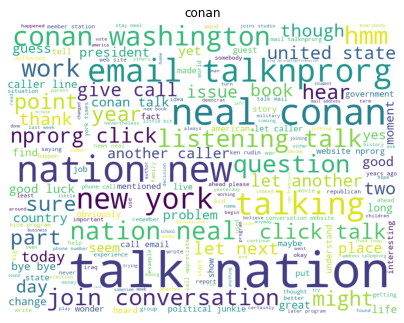

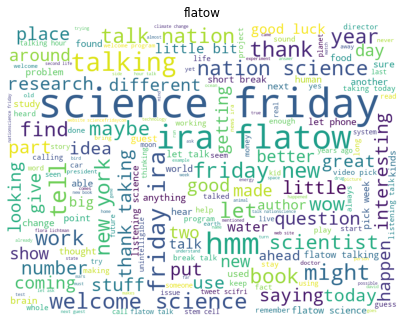

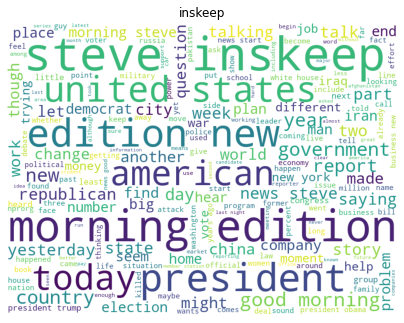

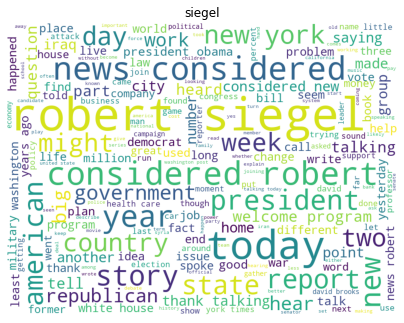

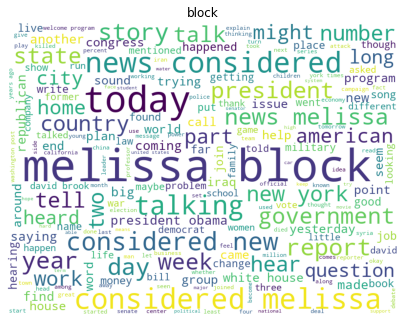

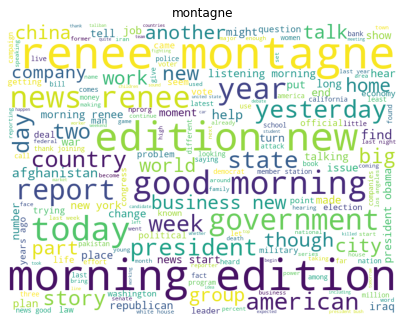

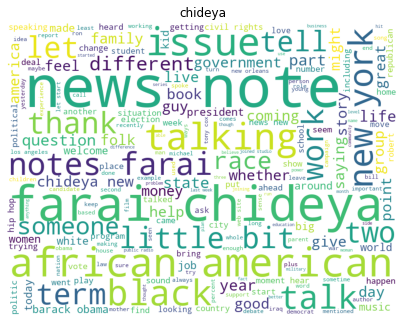

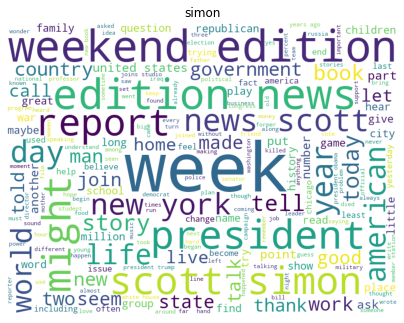

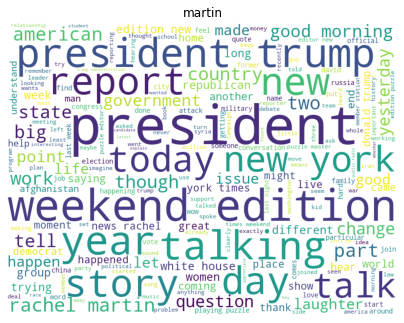

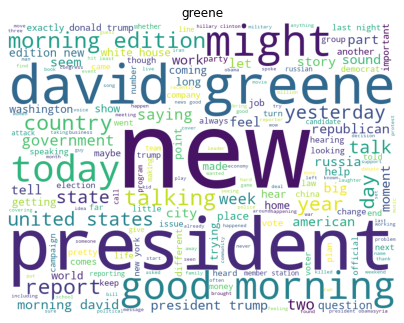

In [ ]:
# word clouds
for h in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

In [ ]:
# find mean character count of each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').message_length.mean())
# find mean word count of each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.mean())
# find total word count for each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.sum())

speaker
david greene      181.314227
farai chideya     190.773745
ira flatow        123.728728
melissa block     164.544794
neal conan        149.523368
rachel martin     160.131414
renee montagne    172.424014
robert siegel     173.099124
scott simon       181.998930
steve inskeep     168.542085
Name: message_length, dtype: float64
speaker
david greene      35.350911
farai chideya     37.762381
ira flatow        25.641285
melissa block     31.882406
neal conan        30.142459
rachel martin     31.284333
renee montagne    32.745851
robert siegel     33.275376
scott simon       35.258801
steve inskeep     32.350712
Name: word_count, dtype: float64
speaker
david greene       601319
farai chideya      770919
ira flatow        1055344
melissa block      710340
neal conan        4308322
rachel martin      549916
renee montagne     682620
robert siegel      922826
scott simon        658987
steve inskeep     1081549
Name: word_count, dtype: int64


In [ ]:
# each speaker's character count by story
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).message_length.sum()

speaker        story_id_num
david greene   777             1547
               778              450
               780              246
               783              326
               800              528
                               ... 
steve inskeep  133180           234
               133182           338
               133184           396
               135547           365
               138265          1115
Name: message_length, Length: 57277, dtype: int64

In [ ]:
# find each speaker's word count per story
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).word_count.sum()

speaker        story_id_num
david greene   777             305
               778              80
               780              48
               783              53
               800              91
                              ... 
steve inskeep  133180           43
               133182           59
               133184           69
               135547           69
               138265          209
Name: word_count, Length: 57277, dtype: int64

In [ ]:
# train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).word_count.mean()

## Are there words that are said more frequently by each host?

In [ ]:
# create empty dicitonary
top_words_by_host = {}

# populate dictionary with dataframes of each hosts' top 20 words compared to other hosts
for host in word_counts.columns.to_list():
    top_words_by_host[host] = pd.DataFrame(word_counts.sort_values(host, ascending = False).head(20))

In [ ]:
top_words_by_host['conan']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
talk,18348,3853,940,568,768,472,999,411,531,533
let,13744,3356,1608,588,605,598,1592,647,739,955
nation,13478,854,271,195,150,211,176,155,74,124
today,10651,1334,1520,2394,1845,1221,861,516,659,787
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
call,9642,583,288,223,210,167,224,245,217,167
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
also,8812,1929,1604,1091,820,904,1595,611,604,818
email,7610,57,50,35,34,28,16,27,30,31
talking,6981,2702,703,1337,847,339,870,223,571,704


In [ ]:
top_words_by_host['flatow']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
science,854,5484,151,141,73,113,81,86,71,108
talk,18348,3853,940,568,768,472,999,411,531,533
friday,479,3721,103,125,101,69,83,88,74,72
let,13744,3356,1608,588,605,598,1592,647,739,955
talking,6981,2702,703,1337,847,339,870,223,571,704
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
hmm,4353,2407,77,97,73,14,50,112,14,16
ira,230,2192,2,9,5,4,5,2,3,4
flatow,160,2112,0,1,0,0,2,1,0,0
thank,4135,1966,146,912,280,523,977,400,348,238


In [ ]:
top_words_by_host['inskeep']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,621,49,3732,207,182,3048,49,183,888,1887
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
steve,857,200,2069,105,86,285,25,78,125,261
inskeep,30,0,1988,4,8,106,0,4,19,67
edition,382,23,1962,33,52,1715,10,845,735,706
reports,390,56,1948,1527,1314,1912,99,626,373,661
good,5226,1732,1632,596,410,1209,538,473,825,1132
let,13744,3356,1608,588,605,598,1592,647,739,955


In [ ]:
top_words_by_host['siegel']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
robert,1125,141,169,2882,210,144,444,113,101,90
siegel,46,2,2,2689,37,1,1,4,5,3
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
today,10651,1334,1520,2394,1845,1221,861,516,659,787
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
considered,546,31,165,1864,1774,110,64,127,74,81
reports,390,56,1948,1527,1314,1912,99,626,373,661
year,3295,695,1249,1380,855,993,575,707,617,751
talking,6981,2702,703,1337,847,339,870,223,571,704


In [ ]:
top_words_by_host['block']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
block,113,44,51,85,2586,29,30,25,21,30
melissa,122,7,9,72,2574,3,81,18,17,30
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
today,10651,1334,1520,2394,1845,1221,861,516,659,787
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
considered,546,31,165,1864,1774,110,64,127,74,81
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
reports,390,56,1948,1527,1314,1912,99,626,373,661
last,3885,553,1450,972,871,1142,698,729,705,836
year,3295,695,1249,1380,855,993,575,707,617,751


In [ ]:
top_words_by_host['montagne']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,621,49,3732,207,182,3048,49,183,888,1887
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
reports,390,56,1948,1527,1314,1912,99,626,373,661
renee,47,1,160,3,4,1775,3,5,4,54
montagne,2,0,82,1,1,1761,0,1,1,24
edition,382,23,1962,33,52,1715,10,845,735,706
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
today,10651,1334,1520,2394,1845,1221,861,516,659,787
good,5226,1732,1632,596,410,1209,538,473,825,1132


In [ ]:
top_words_by_host['chideya']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
black,868,80,254,173,136,161,2027,109,106,150
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
notes,130,30,29,21,21,14,1635,23,19,9
also,8812,1929,1604,1091,820,904,1595,611,604,818
let,13744,3356,1608,588,605,598,1592,647,739,955
african,584,15,166,115,103,120,1321,103,49,67
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
american,2734,333,997,740,406,580,1106,450,361,339
farai,4,0,0,0,0,0,1069,0,0,1


In [ ]:
top_words_by_host['simon']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
week,3008,1067,1091,1037,811,830,560,1404,890,619
weekend,440,300,308,173,187,205,103,999,755,244
years,4434,1001,1481,1286,794,982,646,910,662,653
joins,3698,545,137,546,371,231,103,906,435,169
edition,382,23,1962,33,52,1715,10,845,735,706
scott,591,109,377,242,204,166,52,791,271,253
world,2310,616,1054,687,471,652,435,757,348,435


In [ ]:
top_words_by_host['martin']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
trump,16,2,1063,504,42,166,8,469,1112,1082
puzzle,169,15,3,10,34,22,1,2,956,42
week,3008,1067,1091,1037,811,830,560,1404,890,619
morning,621,49,3732,207,182,3048,49,183,888,1887
good,5226,1732,1632,596,410,1209,538,473,825,1132
weekend,440,300,308,173,187,205,103,999,755,244
let,13744,3356,1608,588,605,598,1592,647,739,955
edition,382,23,1962,33,52,1715,10,845,735,706


In [ ]:
top_words_by_host['greene']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,621,49,3732,207,182,3048,49,183,888,1887
president,5001,535,3160,1895,1369,1474,1177,1517,1586,1703
new,10310,2474,2250,2593,1796,1930,2009,1691,1363,1351
good,5226,1732,1632,596,410,1209,538,473,825,1132
david,2471,351,675,906,749,459,130,274,287,1092
trump,16,2,1063,504,42,166,8,469,1112,1082
news,9352,1146,3200,2312,1982,2611,2745,1528,691,1054
let,13744,3356,1608,588,605,598,1592,647,739,955
could,3469,1531,1188,931,666,744,603,752,548,882
last,3885,553,1450,972,871,1142,698,729,705,836


### Are there words more frequently said by hosts vs guests?

due to length I will not run this yet

In [ ]:
# guest_df = pd.DataFrame(train[~train.speaker.isin(hosts_with_the_most)].groupby('is_host')['clean'].agg(lambda col: ' '.join(col))).T

In [ ]:
# guest_words = guest_df[0]

In [ ]:
# guest_words = train[~train.speaker.isin(hosts_with_the_most)].groupby('is_host')['clean'].agg(lambda col: ' '.join(col)).T
# guest_freq = pd.Series(guest_words).value_counts()
# 

## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

The data is large and has to be sampled.

In [ ]:
df2 = df.sample(10_000, random_state = 222)

train, validate, test = wrangle.split_data(df2)

Check df shapes

In [ ]:
print(train.shape)
print(validate.shape)
print(test.shape)

(5600, 14)
(2400, 14)
(2000, 14)


Function to scale data for clustering

In [ ]:
train.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,message_length,word_count,question_mark_count
445993,35255,4,ira flatow,You're very welcome. Why the - this very - thi...,talk of the nation,"an ocean full of 'sex, drugs and sea slime'",True,you re very welcome. why the this very this bo...,you re very welcome. why the this very this bo...,0.5095,2011-07-01,139,28,0
198185,90737,4,newt gingrich,I thought it was a very positive meeting.,morning edition,the awkward post-election white house lunch,False,i thought it was a very positive meeting .,i thought it wa a very positive meeting .,0.5984,2014-11-07,42,9,0
1613573,63830,32,paul farhi,"Well, I think the first surfacing of this is b...",morning edition,"news brief: government shutdown threat looms, ...",False,"well , i think the first surfacing of this is ...","well , i think the first surfacing of this is ...",-0.2732,2018-01-19,416,76,0
369093,134055,15,melissa block,That's NPR's Lourdes Garcia-Navarro speaking w...,all things considered,panama begins bid to widen the canal,True,that s npr s lourdes garcia navarro speaking w...,that s npr s lourdes garcia navarro speaking w...,0.7964,2007-09-03,207,41,0
1003919,72987,10,david greene,And I guess there is an important distinction ...,weekend edition saturday,"the tsa's tweeting, but not all agencies feel ...",True,and i guess there is an important distinction ...,and i guess there is an important distinction ...,0.6542,2009-08-15,448,87,0


In [ ]:
def min_max_scaler(train, valid, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    train[num_vars] = scaler.fit_transform(train[num_vars])
    valid[num_vars] = scaler.transform(valid[num_vars])
    test[num_vars] = scaler.transform(test[num_vars])
    return scaler, train, valid, test

In [ ]:
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [ ]:
# define features for clustering
X_train_cluster = train_scaled[['vader', 'word_count','question_mark_count']]

#repeat for validate and test
X_validate_cluster = validate_scaled[['vader', 'word_count','question_mark_count']]
X_test_cluster = test_scaled[['vader', 'word_count','question_mark_count']]

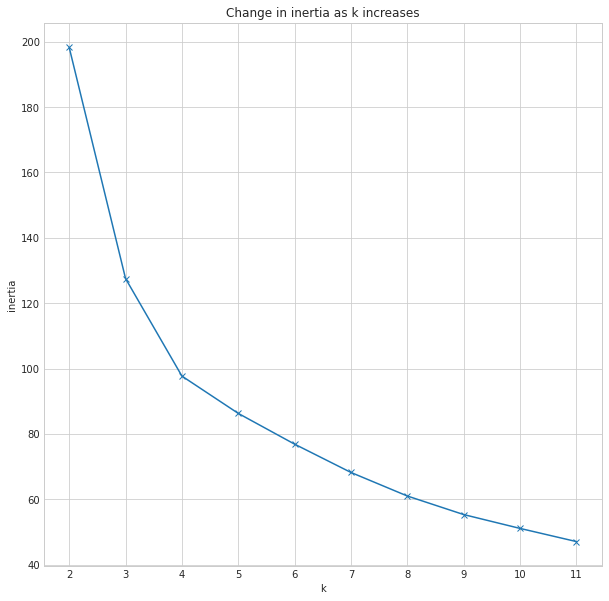

In [ ]:
# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

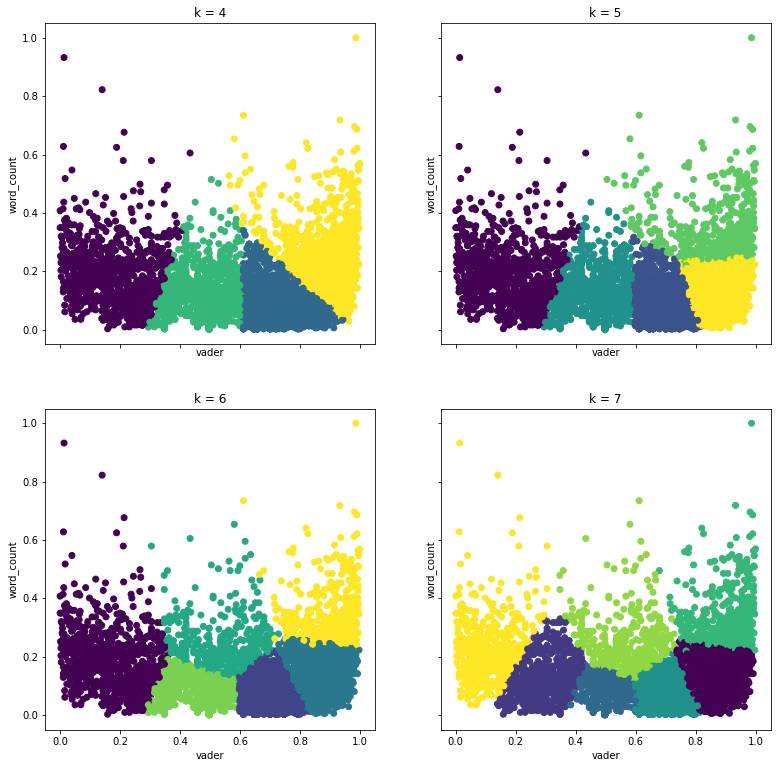

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(4, 8)):
    clusters = KMeans(k).fit(X_train_cluster).predict(X_train_cluster)
    ax.scatter(X_train_cluster.vader, X_train_cluster.word_count, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='vader', ylabel='word_count')

In [ ]:
# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 333)
# fit cluster object to features
kmeans.fit(X_train_cluster)
# use the object
kmeans.predict(X_train_cluster);

In [ ]:
# add cluster features to train and X_train df's
train_scaled['cluster'] = kmeans.predict(X_train_cluster)
validate_scaled['cluster'] = kmeans.predict(X_validate_cluster)
test_scaled['cluster'] = kmeans.predict(X_test_cluster)
X_train_cluster['cluster'] = kmeans.predict(X_train_cluster)

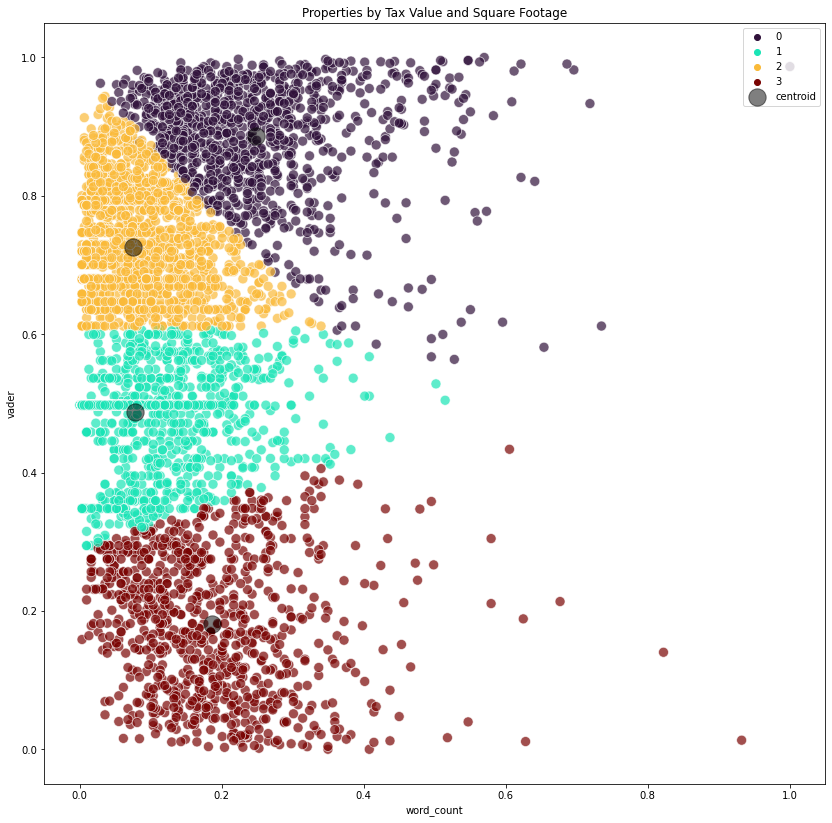

In [ ]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_cluster.loc[:, X_train_cluster.columns != 'cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_cluster, x = 'word_count', y = 'vader', hue = 'cluster', s = 100, alpha = 0.7, palette = 'turbo')
centroids.plot.scatter(x='word_count',y='vader',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Properties by Tax Value and Square Footage')
plt.legend(loc = 'upper right')

### 3D CLUSTERS?

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

Text(0.5, 0.92, 'NPR Clusters by vader, word_count, question_mark_count')

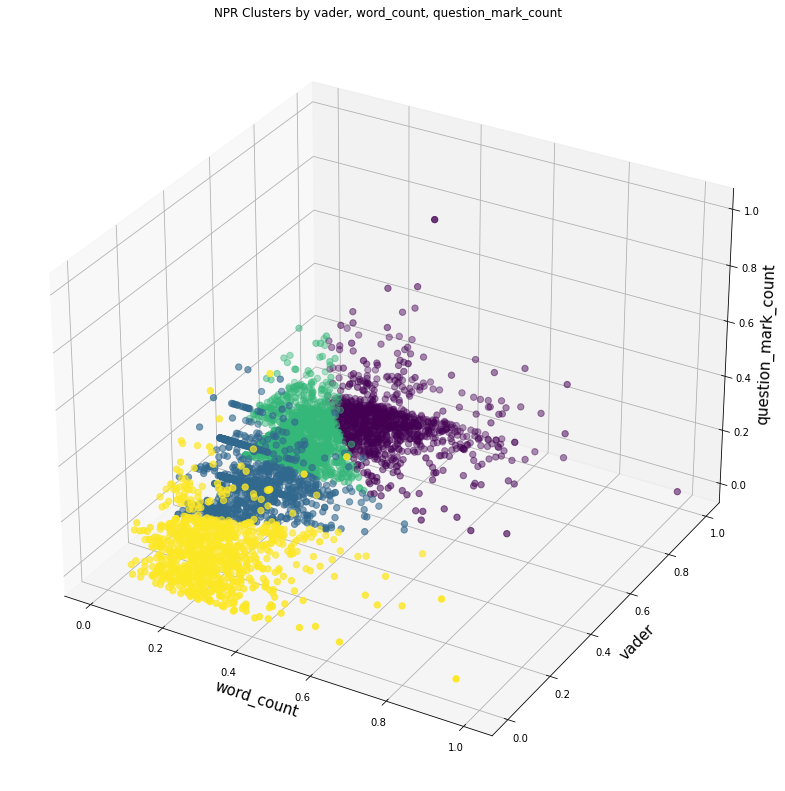

In [ ]:
# plt.figure(figsize = (14,14))
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, projection = '3d')

x = X_train_cluster.word_count
y = X_train_cluster.vader
z = X_train_cluster.question_mark_count
ax.scatter(x,y,z, c=X_train_cluster.cluster, s = 40)
# ax.legend()
ax.set_xlabel('word_count', fontsize = 15)
ax.set_ylabel('vader',fontsize = 15)
ax.set_zlabel('question_mark_count',fontsize = 15)
plt.title('NPR Clusters by vader, word_count, question_mark_count')

### Stats?



$H0$: Means between clusters are equal

$Ha$: Means between clusters are not equal


In [ ]:
from scipy import stats
alpha = 0.5

In [ ]:
f, p = stats.f_oneway(train_scaled[train_scaled.cluster == 0].cluster,
                     train_scaled[train_scaled.cluster == 1].cluster,
                     train_scaled[train_scaled.cluster == 2].cluster,
                     train_scaled[train_scaled.cluster == 3].cluster)

In [ ]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis



$H0$: No correlation between clusters and being a host

$Ha$: Correlation between clusters and being a host

In [ ]:
x = train_scaled.cluster
y = train_scaled.is_host

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


## Model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import scipy as sp

### TF-IDF, X and y

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define utterances
utterances = [utterance for utterance in train.lemmatized]

# create tfidf object
tfidf = TfidfVectorizer()

# fit/use tfidf
#train
train_tfidf = tfidf.fit_transform(utterances)

#validate
validate_tfidf = tfidf.transform([utterance for utterance in validate.lemmatized])

#test
test_tfidf = tfidf.transform([utterance for utterance in test.lemmatized])

In [ ]:
train_tfidf = sp.sparse.hstack((train_tfidf, 
                                pd.DataFrame(train.question_mark_count),
                                pd.DataFrame(train.vader),
                                pd.DataFrame(train.word_count)))
                                # pd.DataFrame(train.cluster)))

validate_tfidf = sp.sparse.hstack((validate_tfidf, 
                                pd.DataFrame(validate.question_mark_count),
                                pd.DataFrame(validate.vader),
                                pd.DataFrame(validate.word_count)))
                                # pd.DataFrame(validate.cluster)))

test_tfidf = sp.sparse.hstack((test_tfidf, 
                                pd.DataFrame(test.question_mark_count),
                                pd.DataFrame(test.vader),
                                pd.DataFrame(test.word_count)))
                                # pd.DataFrame(test.cluster)))

In [ ]:
print(train_tfidf.shape)
print(validate_tfidf.shape)
print(test_tfidf.shape)

(5600, 14588)
(2400, 14588)
(2000, 14588)


In [ ]:
# drop columns not needed for modeling
features = train.drop(columns = ['story_id_num','utterance_order','speaker','utterance','program','title','is_host','clean','lemmatized','date']).columns.to_list()

In [ ]:
## Create X and y for train, validate, test
# X_train = train[features]
y_train = train.is_host

# X_validate = validate[features]
y_validate = validate.is_host

# X_test = test[features]
y_test = test.is_host

## X_train + TF_IDF
X_train = train_tfidf

X_validate = validate_tfidf

X_test = test_tfidf

### Baseline

Nobody's a host!

In [ ]:
# create baseline on mode (is_host == False)
train['baseline_pred'] = False
validate['baseline_pred'] = False
test['baseline_pred'] = False

print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.baseline_pred)))
print('---')
print(classification_report(train.is_host, train.baseline_pred))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.baseline_pred)))
print('---')
print(classification_report(validate.is_host, validate.baseline_pred))

Train Accuracy: 62.32%
---
              precision    recall  f1-score   support

       False       0.62      1.00      0.77      3490
        True       0.00      0.00      0.00      2110

    accuracy                           0.62      5600
   macro avg       0.31      0.50      0.38      5600
weighted avg       0.39      0.62      0.48      5600

Validate Accuracy: 62.33%
---
              precision    recall  f1-score   support

       False       0.62      1.00      0.77      1496
        True       0.00      0.00      0.00       904

    accuracy                           0.62      2400
   macro avg       0.31      0.50      0.38      2400
weighted avg       0.39      0.62      0.48      2400



### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)
clf = clf.fit(X_train, y_train)
train['predicted_clf'] = clf.predict(X_train)

validate['predicted_clf'] = clf.predict(X_validate)

In [ ]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.predicted_clf)))
print('---')
print(classification_report(train.is_host, train.predicted_clf))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.predicted_clf)))
print('---')
print(classification_report(validate.is_host, validate.predicted_clf))

Train Accuracy: 74.68%
---
              precision    recall  f1-score   support

       False       0.73      0.93      0.82      3490
        True       0.80      0.44      0.57      2110

    accuracy                           0.75      5600
   macro avg       0.77      0.69      0.69      5600
weighted avg       0.76      0.75      0.72      5600

Validate Accuracy: 74.71%
---
              precision    recall  f1-score   support

       False       0.74      0.92      0.82      1496
        True       0.78      0.46      0.58       904

    accuracy                           0.75      2400
   macro avg       0.76      0.69      0.70      2400
weighted avg       0.75      0.75      0.73      2400



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_leaf=3,criterion='gini',max_depth=2,random_state=222)

rf.fit(X_train, y_train)
train['predicted_rf'] = rf.predict(X_train)

validate['predicted_rf'] = rf.predict(X_validate)

In [ ]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.predicted_rf)))
print('---')
print(classification_report(train.is_host, train.predicted_rf))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.predicted_rf)))
print('---')
print(classification_report(validate.is_host, validate.predicted_rf))

Train Accuracy: 62.32%
---
              precision    recall  f1-score   support

       False       0.62      1.00      0.77      3490
        True       0.00      0.00      0.00      2110

    accuracy                           0.62      5600
   macro avg       0.31      0.50      0.38      5600
weighted avg       0.39      0.62      0.48      5600

Validate Accuracy: 62.33%
---
              precision    recall  f1-score   support

       False       0.62      1.00      0.77      1496
        True       0.00      0.00      0.00       904

    accuracy                           0.62      2400
   macro avg       0.31      0.50      0.38      2400
weighted avg       0.39      0.62      0.48      2400



### Current Modeling Takeaways
Decision Tree with TF-IDF and variables added had highest accuracy

Random Forest perfomred best without TF-IDF.